# Data augmentation using cGAN

The idea is to generate new and very realistic synthetic data based on labels. GANs are excellent at generating realistic data. We can condition this generation by using [Conditional Generative Adversarial Networks](https://arxiv.org/abs/1411.1784)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
latent_dim = 100 # dimension of the latent space
n_samples = 1000 # size of our dataset
n_classes = 3
n_features = 2 # we use 2 features since we'd like to visualize them

We start by creating random clusters of points, `n_classes`, with features, `n_features`. We make use of `make_blobs` from scikit learn that generates gaussian blobs

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=n_samples, centers=n_classes, n_features=n_features)

Following we normalize our features to help with the learning

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [7]:
scaled_X = scaler.fit_transform(X)

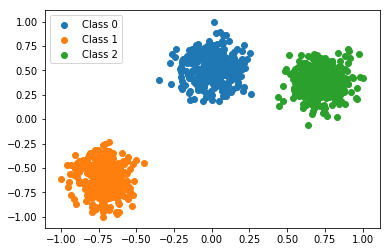

In [8]:
legend = []

for i in range(n_classes):
    plt.scatter(scaled_X[:, 0][np.where(y==i)], scaled_X[:, 1][np.where(y==i)])
    legend.append('Class %d' % i)

plt.legend(legend)

In [9]:
# Core layers
from keras.layers \
    import Activation, Dropout, Flatten, Dense, Input, LeakyReLU

# Normalization layers
from keras.layers import BatchNormalization

# Merge layers
from keras.layers import concatenate, multiply

# Embedding Layers
from keras.layers import Embedding

# Keras models
from keras.models import Model, Sequential

# Keras optimizers
from keras.optimizers import Adam, RMSprop, SGD

import keras.backend as K

Using TensorFlow backend.


In [10]:
def build_discriminator(optimizer=Adam(0.0002, 0.5)):
    '''
    Defines and compiles discriminator model.
    This architecture has been inspired by:
    https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
    and adapted for this problem.
    
    Params:
        optimizer=Adam(0.0002, 0.5) - recommended values
    '''
    features = Input(shape=(n_features,))
    label = Input(shape=(1,), dtype='int32')
    
    # Using an Embedding layer is recommended by the papers
    label_embedding = Flatten()(Embedding(n_classes, n_features)(label))
    
    # We condition the discrimination of generated features 
    inputs = multiply([features, label_embedding])
    
    x = Dense(512)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    model = Model([features, label], valid)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [11]:
def build_generator():
    '''
    Defines the generator model.
    This architecture has been inspired by:
    https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
    and adapted for this problem.
    '''
    
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    
    # Using an Embedding layer is recommended by the papers
    label_embedding = Flatten()(Embedding(n_classes, latent_dim)(label))
    
    # We condition the generation of features
    inputs = multiply([noise, label_embedding])
    
    x = Dense(256)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    features = Dense(n_features, activation='tanh')(x)
    
    model = Model([noise, label], features)
    model.summary()

    return model

In [12]:
def build_gan(generator, discriminator, optimizer=Adam(0.0002, 0.5)):
    '''
    Defines and compiles GAN model. It bassically chains Generator
    and Discriminator in an assembly-line sort of way where the input is
    the Generator's input. The Generator's output is the input of the Discriminator,
    which outputs the output of the whole GAN.
    
    Params:
        optimizer=Adam(0.0002, 0.5) - recommended values
    '''
    
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,))
    
    features = generator([noise, label])
    valid = discriminator([features, label])
    
    # We freeze the discriminator's layers since we're only 
    # interested in the generator and its learning
    discriminator.trainable = False
    
    model = Model([noise, label], valid)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [13]:
discriminator = build_discriminator()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         6           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2)            0           embedding_1[0][0]                
__________________________________________________________________________________________________
multiply_1

In [14]:
generator = build_generator()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       300         input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_2

In [15]:
gan = build_gan(generator, discriminator)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 2)            692270      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            527367      model_2[1][0]                    
          

In [16]:
def get_random_batch(X, y, batch_size):
    '''
    Will return random batches of size batch_size
    
    Params:
        X: numpy array - features
        y: numpy array - classes
        batch_size: Int
    '''
    idx = np.random.randint(0, len(X))
    
    X_batch = X[idx:idx+batch_size]
    y_batch = y[idx:idx+batch_size]
    
    return X_batch, y_batch

In [17]:
def train_gan(gan, generator, discriminator, 
              X, y, 
              n_epochs=10000, batch_size=32, 
              hist_every=10, log_every=100):
    '''
    Trains discriminator and generator (last one through the GAN) 
    separately in batches of size batch_size. The training goes as follow:
        1. Discriminator is trained with real features from our training data
        2. Discriminator is trained with fake features generated by the Generator
        3. GAN is trained, which will only change the Generator's weights.
        
    Params:
        gan: GAN model
        generator: Generator model
        discriminator: Discriminator model
        X: numpy array - features
        y: numpy array - classes
        n_epochs: Int
        batch_size: Int
        hist_every: Int - will save the training loss and accuracy every hist_every epochs
        log_every: Int - will output the loss and accuracy every log_every epochs
    
    Returns:
        loss_real_hist: List of Floats
        acc_real_hist: List of Floats
        loss_fake_hist: List of Floats
        acc_fake_hist: List of Floats
        loss_gan_hist: List of Floats
        acc_gan_hist: List of Floats
    '''
    
    half_batch = int(batch_size / 2)
    
    acc_real_hist = []
    acc_fake_hist = []
    acc_gan_hist = []
    loss_real_hist = []
    loss_fake_hist = []
    loss_gan_hist = []
    
    for epoch in range(n_epochs):
        
        X_batch, labels = get_random_batch(X, y, batch_size)
        
        # train with real values
        y_real = np.ones((X_batch.shape[0], 1))
        loss_real, acc_real = discriminator.train_on_batch([X_batch, labels], y_real)
        
        # train with fake values
        noise = np.random.uniform(0, 1, (labels.shape[0], latent_dim))
        X_fake = generator.predict([noise, labels])
        y_fake = np.zeros((X_fake.shape[0], 1))
        loss_fake, acc_fake = discriminator.train_on_batch([X_fake, labels], y_fake)
        
        y_gan = np.ones((labels.shape[0], 1))
        loss_gan, acc_gan = gan.train_on_batch([noise, labels], y_gan)
        
        if (epoch+1) % hist_every == 0:
            acc_real_hist.append(acc_real)
            acc_fake_hist.append(acc_fake)
            acc_gan_hist.append(acc_gan)
            loss_real_hist.append(loss_real)
            loss_fake_hist.append(loss_fake)
            loss_gan_hist.append(loss_gan)

        if (epoch+1) % log_every == 0:
            lr = 'loss real: {:.3f}'.format(loss_real)
            ar = 'acc real: {:.3f}'.format(acc_real)
            lf = 'loss fake: {:.3f}'.format(loss_fake)
            af = 'acc fake: {:.3f}'.format(acc_fake)
            lg = 'loss gan: {:.3f}'.format(loss_gan)
            ag = 'acc gan: {:.3f}'.format(acc_gan)

            print('{}, {} | {}, {} | {}, {}'.format(lr, ar, lf, af, lg, ag))
        
    return loss_real_hist, acc_real_hist, loss_fake_hist, acc_fake_hist, loss_gan_hist, acc_gan_hist

In [18]:
loss_real_hist, acc_real_hist, \
loss_fake_hist, acc_fake_hist, \
loss_gan_hist, acc_gan_hist = train_gan(gan, generator, discriminator, scaled_X, y)

/root/.jupyter/venvs/py36/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


loss real: 0.544, acc real: 0.719 | loss fake: 0.522, acc fake: 0.719 | loss gan: 1.249, acc gan: 0.281
loss real: 0.175, acc real: 0.969 | loss fake: 0.056, acc fake: 1.000 | loss gan: 3.002, acc gan: 0.062
loss real: 0.116, acc real: 0.969 | loss fake: 0.077, acc fake: 1.000 | loss gan: 3.866, acc gan: 0.000
loss real: 0.077, acc real: 1.000 | loss fake: 0.175, acc fake: 0.938 | loss gan: 4.488, acc gan: 0.156
loss real: 0.204, acc real: 0.938 | loss fake: 0.118, acc fake: 1.000 | loss gan: 4.460, acc gan: 0.000
loss real: 0.118, acc real: 0.969 | loss fake: 0.105, acc fake: 1.000 | loss gan: 5.204, acc gan: 0.000
loss real: 0.443, acc real: 0.812 | loss fake: 0.507, acc fake: 0.656 | loss gan: 2.171, acc gan: 0.344
loss real: 0.190, acc real: 0.969 | loss fake: 0.031, acc fake: 1.000 | loss gan: 5.347, acc gan: 0.000
loss real: 0.720, acc real: 0.594 | loss fake: 0.899, acc fake: 0.219 | loss gan: 0.935, acc gan: 0.594
loss real: 0.698, acc real: 0.438 | loss fake: 0.709, acc fake: 

loss real: 0.694, acc real: 0.469 | loss fake: 0.694, acc fake: 0.531 | loss gan: 0.694, acc gan: 0.469
loss real: 0.695, acc real: 0.469 | loss fake: 0.691, acc fake: 0.562 | loss gan: 0.695, acc gan: 0.469
loss real: 0.690, acc real: 0.594 | loss fake: 0.701, acc fake: 0.312 | loss gan: 0.689, acc gan: 0.531
loss real: 0.696, acc real: 0.469 | loss fake: 0.682, acc fake: 0.656 | loss gan: 0.715, acc gan: 0.312
loss real: 0.618, acc real: 0.656 | loss fake: 0.703, acc fake: 0.438 | loss gan: 0.687, acc gan: 0.594
loss real: 0.710, acc real: 0.312 | loss fake: 0.692, acc fake: 0.438 | loss gan: 0.699, acc gan: 0.500
loss real: 0.693, acc real: 0.406 | loss fake: 0.710, acc fake: 0.531 | loss gan: 0.684, acc gan: 0.438
loss real: 0.697, acc real: 0.462 | loss fake: 0.682, acc fake: 0.846 | loss gan: 0.709, acc gan: 0.231
loss real: 0.703, acc real: 0.250 | loss fake: 0.681, acc fake: 0.719 | loss gan: 0.704, acc gan: 0.312
loss real: 0.690, acc real: 0.625 | loss fake: 0.697, acc fake: 

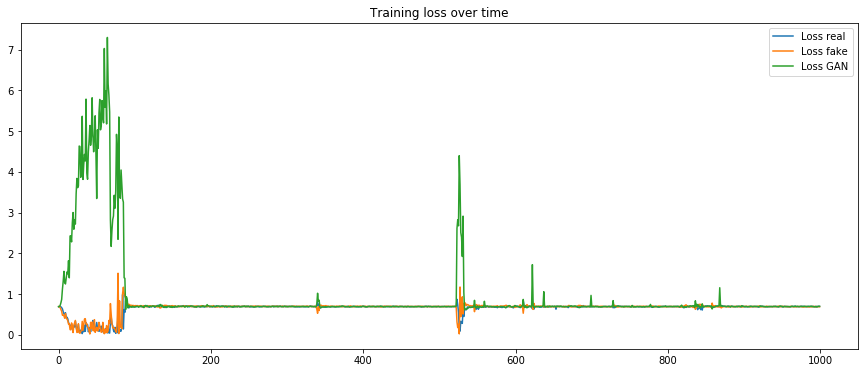

In [19]:
ax, fig = plt.subplots(figsize=(15, 6))
plt.plot(loss_real_hist)
plt.plot(loss_fake_hist)
plt.plot(loss_gan_hist)
plt.title('Training loss over time')
plt.legend(['Loss real', 'Loss fake', 'Loss GAN'])

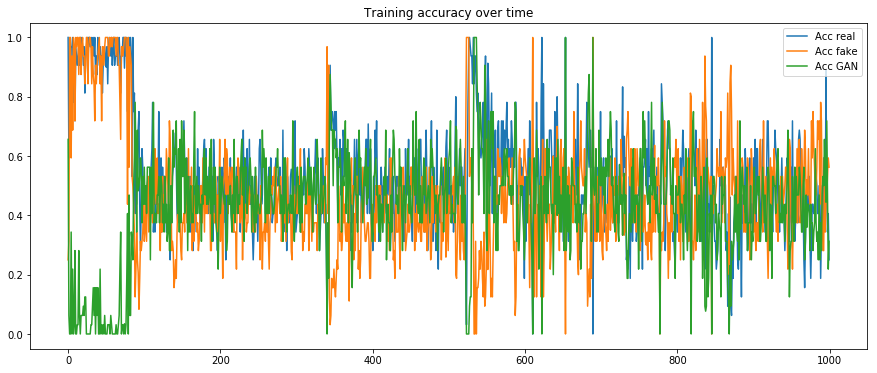

In [20]:
ax, fig = plt.subplots(figsize=(15, 6))
plt.plot(acc_real_hist)
plt.plot(acc_fake_hist)
plt.plot(acc_gan_hist)
plt.title('Training accuracy over time')
plt.legend(['Acc real', 'Acc fake', 'Acc GAN'])

In [21]:
def generate_samples(class_for, n_samples=10):
    '''
    Generates new random but very realistic features
    
    Params:
        class_for: Int - features for this class
        n_samples: Int - how many samples to generate
    '''
    
    noise = np.random.uniform(0, 1, (n_samples, latent_dim))
    label = np.full((n_samples,), fill_value=class_for)
    return generator.predict([noise, label])

Let's generate new features for class 0

In [22]:
features_class_0 = generate_samples(0)

In [23]:
def visualize_fake_features(fake_features, figsize=(15, 6), color='r'):
    ax, fig = plt.subplots(figsize=figsize)
    
    # Let's plot our dataset to compare
    for i in range(n_classes):
        plt.scatter(scaled_X[:, 0][np.where(y==i)], scaled_X[:, 1][np.where(y==i)])

    plt.scatter(fake_features[:, 0], fake_features[:, 1], c=color)
    plt.title('Real and fake features')
    plt.legend(['Class 0', 'Class 1', 'Class 2', 'Fake'])

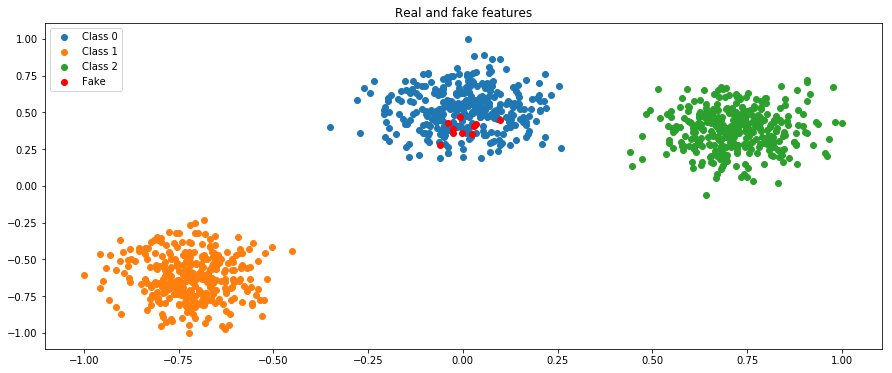

In [24]:
visualize_fake_features(features_class_0)

New features for class 1

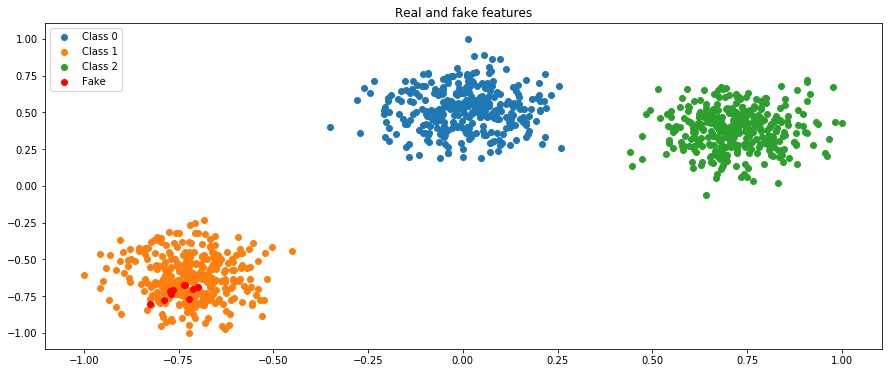

In [25]:
features_class_1 = generate_samples(1)
visualize_fake_features(features_class_1)

New features for class 2

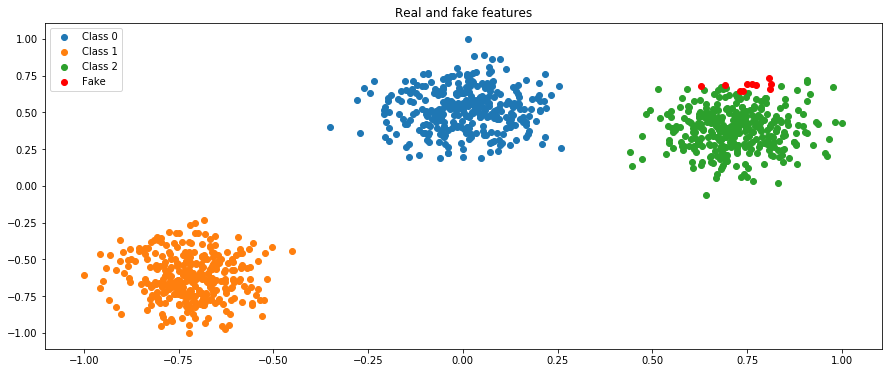

In [26]:
features_class_2 = generate_samples(2)
visualize_fake_features(features_class_2)